In [1]:
!pip install cvxpy

zsh:1: command not found: pip


In [2]:
!pip install -U matplotlib

zsh:1: command not found: pip


In [1]:
from NetworkTopology import *
from NetworkParser import *
from TESolver import *
from MIPSolver import *
from helper import *

# Load the network topology, tunnels and demands

In [2]:
network_name = "b4"
network = parse_topology(network_name)
parse_demands(network)
parse_tunnels(network)
initialize_weights(network)

# Plot the topology of the network

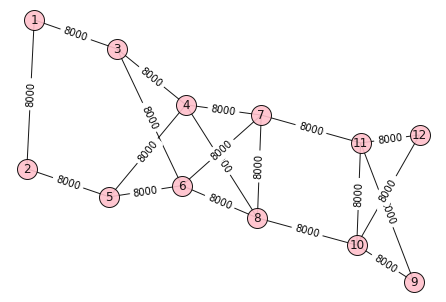

In [3]:
G = network.to_nx()
capacity_labels = {}
for edge in G.edges:
    capacity_labels[edge] = int(network.edges[edge].capacity)
    
plt = network.draw(capacity_labels)
# plt.show()

# Initialize the TE Solver, add constraints and solve the maximum flow objective
* $c_e \geq \sum_{t \ni e} f(t)$ for each edge $e$
* $demand(d_i) \geq \sum_{t \in d_i} f(t)$ for each demand $d_i$

* Maximize $\sum f(t)$

In [4]:
mip = CvxSolver()
solver = TESolver(mip, network)
solver.add_demand_constraints()
solver.add_edge_capacity_constraints()
solver.add_flow_conservation_constraints()
objective = get_max_flow_objective(network)
solver.Maximize(objective)
max_flow = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Max flow:", max_flow)

Optimal solution was found.
Max flow: 25210.978068112756


# Analyze the results.
## Understand the maximum flow and assignments to different tunnels.

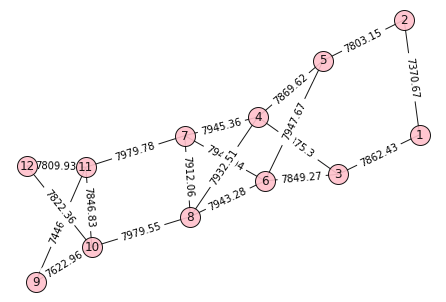

In [5]:
plt = network.draw(get_edge_flow_allocations(network))
plt.show()

# Were all traffic demands met?

In [6]:
if sum(get_demands_unmet(network).values()) == 0:
    print("All demands were met.")
else:
    print("Not all traffic demands could be met")

All demands were met.


# How was traffic split across tunnels?
## Did the TE achieve a good split of traffic over different tunnels, investigate here

In [7]:
# print per demand and per tunnel allocations in over the graph here


# Traffic engineering with max flow and minimum latency

In [8]:
objective = get_max_flow_min_weight_objective(network, epsilon=0.1)
solver.Maximize(objective)
max_flow = solver.solve()

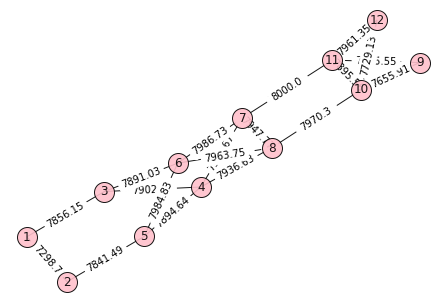

In [9]:
plt = network.draw(get_edge_flow_allocations(network))
plt.show()

In [26]:
pos = nx.spring_layout(G)
fig = plt.figure()
fig.draw(G, pos, edge_color = 'black', linewidths = 1,\
        node_size = 400,node_color = 'pink',alpha = 0.9, with_labels = True)
# 	nx.draw_networkx_edge_labels(G, pos, labels)
#         ax = plt.gca()
# 	ax.collections[0].set_edgecolor("#000000")
#         plt.axis('off')
#         # plt.show()

AttributeError: 'Graph' object has no attribute '_rasterizing'

<Figure size 432x288 with 0 Axes>

In [11]:
tunnels = [x.split(':') for x in network.tunnels.keys()]
edges = []
for tunnel in tunnels:
    tunnel_edges = [(tunnel[n],tunnel[n+1]) for n in range(len(tunnel)-1)]
    edges.append(tunnel_edges)


0
1
2
3


IndexError: list index out of range

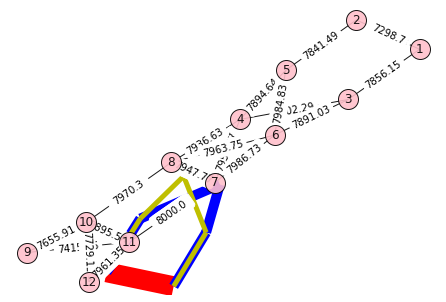

In [19]:
plt = network.draw(get_edge_flow_allocations(network))
pos = nx.spring_layout(G)
colors = ['r', 'b', 'y']
linewidths = [20,10,5]
for ctr, edgelist in enumerate(edges):
    print(ctr)
    nx.draw_networkx_edges(G,pos, edgelist=edgelist,edge_color = colors[ctr], width=linewidths[ctr])

# Forward-fault correction
For failure groups $F_1, \ldots, F_k$. Each failure group contains a set of edges that are disabled.
For each failure group $F_i$:



`* $\alpha_i(t) = \alpha_i(e_1) \cdots \alpha_i(e_k)$ where $t = e_1, \ldots, e_k$.



Then the following constraints solve for a flow $f(t)$, such that edge capacities are not exceeded and the worst case failure scenario bandwdith allocation for a demand $d$ is $b_d$. The FFC TE goal is to minimize the accumulated gap between $b_d$ and the demand $d$.



* $\sum_{t \ni e} \alpha_i(e) \cdot f(t) \leq c_e$ for each edge $e$, each failure scenario $i$.
* $b_d \leq \sum_{t \in d} \alpha_i(t) \cdot f(t)$
* $b_d \leq d$ for each demand $d$, each failure $i$.
* $0 \leq f(t)$ each tunnel $t$



* Maximize $\sum_d b_d$

In [14]:
mip = CvxSolver()
solver = FFCSolver(mip, network)
solver.add_demand_constraints()

# Enumerate single link failures (k = 1)
for edge in network.edges:
    # edges are directional tuples, thus, failing (a,b) implies that (b,a) also fails.
    edges = set([network.edges[edge], network.edges[edge[::-1]]])
    solver.failure_scenario_edge_constraint(edges)

objective = get_ffc_objective(network)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Optimal objective:", obj)

Failing links will prevent meeting the demands between 9-1
9 1 [('3', '1'), ('1', '3')]
Failing links will prevent meeting the demands between 12-1
12 1 [('3', '1'), ('1', '3')]
Failing links will prevent meeting the demands between 9-2
9 2 [('2', '5'), ('5', '2')]
Failing links will prevent meeting the demands between 12-2
12 2 [('2', '5'), ('5', '2')]
Failing links will prevent meeting the demands between 9-1
9 1 [('3', '1'), ('1', '3')]
Failing links will prevent meeting the demands between 12-1
12 1 [('3', '1'), ('1', '3')]
Failing links will prevent meeting the demands between 9-2
9 2 [('2', '5'), ('5', '2')]
Failing links will prevent meeting the demands between 12-2
12 2 [('2', '5'), ('5', '2')]
Failing links will prevent meeting the demands between 1-11
1 11 [('7', '11'), ('11', '7')]
Failing links will prevent meeting the demands between 2-11
2 11 [('7', '11'), ('11', '7')]
Failing links will prevent meeting the demands between 1-10
1 10 [('8', '10'), ('10', '8')]
Failing link

In [15]:
for demand in network.demands:
    for tunnel in network.demands[demand].tunnels:
        #print(tunnel.pathstr, tunnel.v_flow.value)
        pass
    
for edge in network.edges.values():
    allocation = 0
    for tunnel in edge.tunnels:
        allocation += tunnel.v_flow.value
    print(edge.e, allocation, edge.capacity)

('2', '1') [7537.08756854] 8000.0
('3', '1') [7544.47637624] 8000.0
('1', '2') [7483.17718313] 8000.0
('5', '2') [7721.5194283] 8000.0
('1', '3') [7640.35926089] 8000.0
('4', '3') [7652.98112164] 8000.0
('6', '3') [7731.72322005] 8000.0
('3', '4') [7477.42695502] 8000.0
('5', '4') [7765.65048184] 8000.0
('7', '4') [7604.4869065] 8000.0
('8', '4') [7475.35789399] 8000.0
('2', '5') [7029.32071294] 8000.0
('4', '5') [7134.81436288] 8000.0
('6', '5') [7534.31793726] 8000.0
('3', '6') [6833.37413778] 8000.0
('5', '6') [7677.07752203] 8000.0
('7', '6') [7357.49016773] 8000.0
('8', '6') [6971.15255184] 8000.0
('4', '7') [7547.98704788] 8000.0
('6', '7') [7720.73169716] 8000.0
('8', '7') [7414.5604866] 8000.0
('11', '7') [7746.78663102] 8000.0
('4', '8') [7633.91289098] 8000.0
('6', '8') [7755.30239823] 8000.0
('7', '8') [7645.17738071] 8000.0
('10', '8') [7789.3777284] 8000.0
('10', '9') [7410.80069794] 8000.0
('11', '9') [7294.30215759] 8000.0
('8', '10') [7999.99999997] 8000.0
('9', '10') [

In [16]:
mip = CvxSolver()
solver = DualFFCSolver(mip, network, 1)
objective = get_ffc_objective(network)
solver.Maximize(objective)
obj = solver.solve()
if mip.problem.status == 'optimal':
    print("Optimal solution was found.")
    print("Optimal objective:", obj)

Optimal solution was found.
Optimal objective: 24873.84297006245


In [17]:
for edge in network.edges.values():
    allocation = 0
    for tunnel in edge.tunnels:
        allocation += tunnel.v_flow.value
    print(edge.e, allocation, edge.capacity)

('2', '1') [65917.94767043] 8000.0
('3', '1') [82421.4426511] 8000.0
('1', '2') [64702.813848] 8000.0
('5', '2') [83695.48870389] 8000.0
('1', '3') [83897.05297163] 8000.0
('4', '3') [97857.08452695] 8000.0
('6', '3') [74848.55969348] 8000.0
('3', '4') [91192.79479416] 8000.0
('5', '4') [93759.35302881] 8000.0
('7', '4') [122931.9847608] 8000.0
('8', '4') [100989.41599489] 8000.0
('2', '5') [82662.16093256] 8000.0
('4', '5') [90858.73924556] 8000.0
('6', '5') [69389.7402531] 8000.0
('3', '6') [79568.3310293] 8000.0
('5', '6') [80614.89820542] 8000.0
('7', '6') [86487.17630629] 8000.0
('8', '6') [69865.59928724] 8000.0
('4', '7') [117383.9376748] 8000.0
('6', '7') [102072.18084947] 8000.0
('8', '7') [90512.2126127] 8000.0
('11', '7') [124736.68349559] 8000.0
('4', '8') [102939.55071414] 8000.0
('6', '8') [77215.61962712] 8000.0
('7', '8') [94422.75065386] 8000.0
('10', '8') [124848.4748318] 8000.0
('10', '9') [53132.30219853] 8000.0
('11', '9') [52930.99405692] 8000.0
('8', '10') [13483

In [18]:
# Debugging dual vs. Primal
import copy
import math
all_demands = copy.deepcopy(network.demands)
for demand_to_keep in all_demands:
    print(len(all_demands), len(network.demands))
    print(demand_to_keep, all_demands[demand_to_keep].amount)
    
    network.demands = {demand_to_keep:all_demands[demand_to_keep]}

    # compare FFC primal and dual
    
    # FFC Primal
    print("FFC Primal Solution")
    mip = CvxSolver()
    # The network should only have one demand now
    assert len(network.demands) == 1
    assert demand_to_keep in network.demands
    solver = FFCSolver(mip, network)
    solver.add_demand_constraints()

    # Enumerate single link failures (k = 1)
    for edge in network.edges:
        # edges are directional tuples, thus, failing (a,b) implies that (b,a) also fails.
        edges = set([network.edges[edge], network.edges[edge[::-1]]])
        solver.failure_scenario_edge_constraint(edges)

    objective = get_ffc_objective(network)
    solver.Maximize(objective)
    max_flow = solver.solve()
    print("Primal Flow", max_flow)
    
    # How was this flow allocated?
    total_flow = 0
    for tunnel in network.demands[demand_to_keep].tunnels:
        total_flow += tunnel.v_flow.value
        print(tunnel.pathstr, tunnel.v_flow.value)

    
    print(max_flow, total_flow[0], all_demands[demand_to_keep].amount)
    # assert math.floor(max_flow) == math.floor(total_flow[0])
    
    print("FFC Dual Solution")
    # FFC Dual
    mip = CvxSolver()
    solver = DualFFCSolver(mip, network, 1)
    objective = get_ffc_objective(network)
    solver.Maximize(objective)
    max_flow = solver.solve()
    print("Dual Flow", max_flow)

    total_flow = 0
    for tunnel in network.demands[demand_to_keep].tunnels:
        print(tunnel.pathstr, tunnel.v_flow.value)
        
    # restore network demands
    network.demands = all_demands
    assert len(network.demands) == len(all_demands)
    

132 132
('1', '2') 18.467129314999998
FFC Primal Solution
Primal Flow 18.467129314995038
1:2 [22.17567005]
1:3:4:5:2 [22.17567005]
1:3:6:5:2 [22.17567005]
1:3:4:7:6:5:2 [22.17567005]
1:3:6:7:4:5:2 [22.17567005]
18.467129314995038 110.87835024453932 18.467129314999998
FFC Dual Solution
Dual Flow 18.467129314950395
1:2 [206.08924143]
1:3:4:5:2 [30.33376015]
1:3:6:5:2 [30.33376015]
1:3:4:7:6:5:2 [84.34821315]
1:3:6:7:4:5:2 [84.34821315]
132 132
('1', '3') 91.654677291
FFC Primal Solution
Primal Flow 91.65467729099998
1:3 [36.82281275]
1:2:5:4:3 [36.82281275]
1:2:5:6:3 [36.82281275]
1:2:5:4:7:6:3 [36.82281275]
1:2:5:6:7:4:3 [36.82281275]
91.65467729099998 184.11406376614974 91.654677291
FFC Dual Solution
Dual Flow 91.65467728837757
1:3 [620.66916877]
1:2:5:4:3 [88.16840428]
1:2:5:6:3 [88.16840428]
1:2:5:4:7:6:3 [259.98926789]
1:2:5:6:7:4:3 [259.98926789]
132 132
('1', '4') 22.451597279
FFC Primal Solution
Primal Flow 22.451597278996466
1:3:4 [22.97322383]
1:2:5:4 [22.97322383]
1:3:6:5:4 [2

KeyboardInterrupt: 

### Path Selection for Traffic Engineering
# K-shortest Paths

# K link-disjoint paths


## Constrained shortest paths
### Brute-force solution for CSP with nodes representing geo-political regions

# Provisioning with traffic engineering

In [ ]:
mip = CvxSolver()
solver = ShooflySolver(mip, network)
solver.demand_constraints()
solver.edge_capacity_constraints()
solver.wavelength_integrality_constraints()
solver.complementary_shortcut_constraints()
solver.flow_conservation_constraints()
objective = get_wavelength_objective(network)
solver.Maximize(objective)

In [ ]:
max_flow = solver.solve()

In [ ]:
mip.problem.status

In [ ]:
max_flow

In [ ]:
[(x, solver.network.shortcuts[x].w_s.value) for x in solver.network.shortcuts]

In [ ]:
for shortcut in solver.network.shortcuts.values():
    y_s_all_tunnels = sum([shortcut.y_s[tunnel] for tunnel in shortcut.tunnels])
    print(y_s_all_tunnels.value, shortcut.w_s.value)

In [ ]:
get_demands_unmet(network)

In [ ]:
tunnels = [(x.split(':'), network.tunnels[x].v_flow.value[0]) for x in network.tunnels]
edges = []
for tunnel, flow in tunnels:
    tunnel_edges = [(tunnel[n],tunnel[n+1]) for n in range(len(tunnel)-1)]
    edges.append([tunnel_edges, flow])

pos = nx.spring_layout(G, weight=1, k=0.5,
                          pos={'1':(0,0), '2':(0,2), '3':(4,2), '4':(4,-2),
                                '5': (8,-1), '6': (8,2), '7': (12,2), '8':(12,-2),
                                '9':(16,0), '10': (16,2), '11': (20, 4), '12': (20, 0)},
                            fixed=['1', '2', '3', '4', '5', '6', '7', '8', '9',
                                '10', '11', '12'])
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
options = {
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 12
}
nx.draw(G, pos, edge_color = 'black', linewidths = 1,
        node_size = 500, node_color = 'pink',
        alpha = 0.9, with_labels = True, **options)
# nx.draw_networkx_edge_labels(G, pos, font_size=8,
#                             label_pos=0.3,
#                             edge_labels=labels)
ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")

colors = ['r', 'b', 'y']
linewidths = [10,5,2]
for edgelist, flow in edges:
    print(ctr)
    nx.draw_networkx_edges(G, pos, edgelist=edgelist,edge_color = colors[ctr], width=linewidths[ctr])
    